In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

np.random.seed(123)


Aquire Titanic data from our mySQL database

In [8]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    df = pd.read_sql(my_query, get_connection('titanic_db'))
    return df


In [9]:
df = get_titanic()
df.head(2).T


,0,1
passenger_id,0,1
survived,0,1
pclass,3,1
sex,male,female
age,22.0,38.0
sibsp,1,1
parch,0,0
fare,7.25,71.2833
embarked,S,C
class,Third,First


In [10]:
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [9]:
# Useful helper for checking for nulls
# What proportion of each column is empty?
df.isna().mean()


passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
dtype: float64

In [11]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df


In [12]:
df = prep_titanic(df)
df.head(2)


,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,S,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,1,0,0


In [18]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test


In [19]:
# Stratify with categorical target variables
train, validate, test = train_validate_test_split(df, target='survived')
train.shape, validate.shape, test.shape


((398, 12), (171, 12), (143, 12))

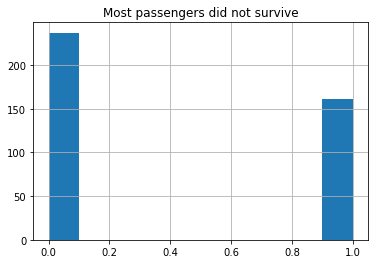

In [20]:
plt.title("Most passengers did not survive")
train.survived.hist()
plt.show()


In [21]:
# We can call .mean() since 0 and 1 are numeric
print("Percent survived from train")
round(train.survived.mean(), 3)


Percent survived from train


0.405

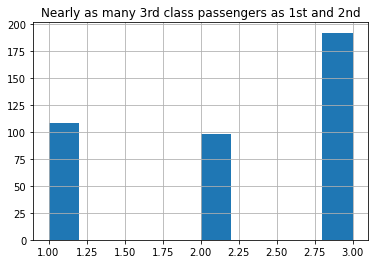

In [23]:
plt.title("Nearly as many 3rd class tickets as 1st and 2nd")
train.pclass.hist()
plt.show()



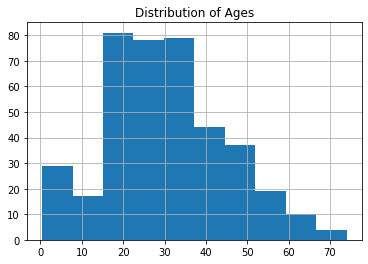

In [24]:
plt.title("Distribution of Ages")
train.age.hist()
plt.show()


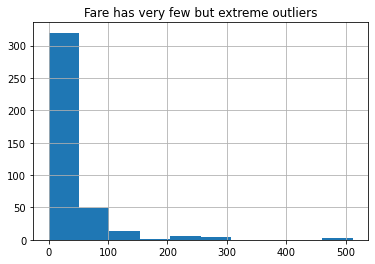

In [25]:
plt.title("Fare has very few but extreme outliers")
train.fare.hist()
plt.show()


In [26]:
train.head(2)


,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
450,0,2,36.0,1,2,27.75,S,0,0,0,0,1
543,1,2,32.0,1,0,26.00,S,0,0,0,0,1


In [27]:
train.head(2)


,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
450,0,2,36.0,1,2,27.75,S,0,0,0,0,1
543,1,2,32.0,1,0,26.00,S,0,0,0,0,1


# Let's Visualize and Test some Categorical Variables to the Target

pclass to survived. What's the relationship between survival and class of ticket?

alone to survived. Is traveling with people more helpful for surviving?

gender to survived. What's the relationship between survival and gender?

fare to survived. What's the relationship between fare and survival?

What further combinations of features could you analyze?

What about binning age into young, middle, and older?

Are there any features that would make sense to create?


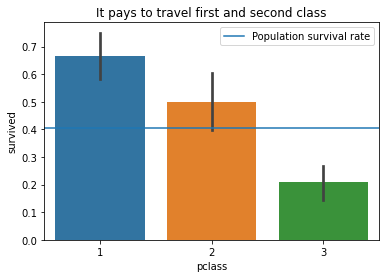

In [28]:
plt.title("It pays to travel first and second class")
sns.barplot(x="pclass", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()


In [29]:
# The above visual is quite clear, but if it was less clear or we want more certainty, we'll run a hypothesis test
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "survival and class of ticket are independent"
alternative_hypothesis = "there is a relationship between class of ticket and survival"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.pclass)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


Reject the null hypothesis that survival and class of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between class of ticket and survival


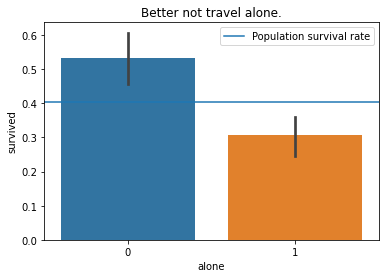

In [30]:
plt.title("Better not travel alone.")
sns.barplot(x="alone", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()


In [31]:
# If the visual was unclear or we need more confirmation, run a hypothesis test
# Let's run a chi squared to compare proportions
alpha = 0.05
null_hypothesis = "survival and traveling alone are independent"
alternative_hypothesis = "there is a relationship between survival and traveling alone"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.alone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


Reject the null hypothesis that survival and traveling alone are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and traveling alone


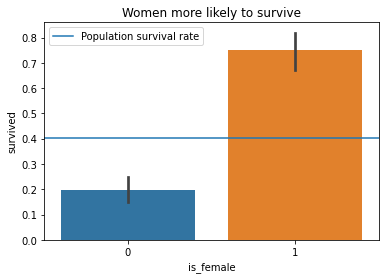

In [32]:
plt.title("Women more likely to survive")
sns.barplot(x="is_female", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()


In [33]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05

null_hypothesis = "survival and gender are independent"
alternative_hypothesis = "there is a relationship between survival and gender"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.is_female)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


Reject the null hypothesis that survival and gender are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and gender


# Comparing Numeric vs. a Categorical Example

If the visual is not completely clear, the need for a hypothesis test increases.

First, set your confidence level and your alpha (Confidence level of 95% and alpha of 0.05 are good)
Select the appropriate test for your 2 variables:
If numeric to numeric, run a correlation test
Compare proportions with 
χ
2
Compare means with t-test or Mann-Whitney u-test.
Run tests, form conclusions, and document your results
(rinse and then repeat with other variables of interest)

1 tailed Mann-Whitney test. For more on Mann-Whitney, see the Wikipedia article

Write down your hypothesis setup

H
0
: Survived passenger fares cost less than or equal to non-surviving passenger fare

H
a
: Surviving passenger fares cost more than non-surviving passenger fares

In [35]:
# Subset the data into survived and not-surviving status
not_survived = train[train.survived == 0]
survived = train[train.survived == 1]


In [36]:
# check variances of the two groups
not_survived.fare.var(), survived.fare.var()


(846.4473286218973, 7299.474755819128)

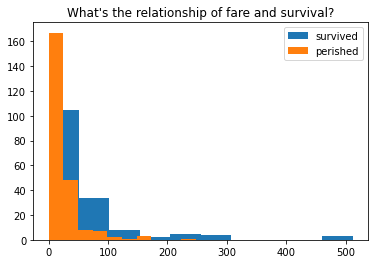

In [37]:
plt.title("What's the relationship of fare and survival?")
plt.hist(survived.fare, label="survived")
plt.hist(not_survived.fare, label="perished")
plt.legend()
plt.show()


In [38]:
from scipy import stats

null_hypothesis = "fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers"
alternative_hypothesis = "fares paid by surviving passengers are higher than non-surviving passengers"

# Use Mann Whitney u-test when t-test assumptions do not hold.
# The distributions are not normal and the variances are not equal, so we'll do mann-whitney
t, p = stats.mannwhitneyu(survived.fare, not_survived.fare, alternative="greater")


In [39]:
if p < alpha:
    print("We find evidence to reject the null hypothesis that", null_hypothesis)
    print("We find evidence evidence to move forward with the understaind that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("There is no evidence that", null_hypothesis)


We find evidence to reject the null hypothesis that fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers
We find evidence evidence to move forward with the understaind that fares paid by surviving passengers are higher than non-surviving passengers


In [40]:
p

4.665118844596931e-14

# Takeaways from bivariate exploration, so far

-It pays to travel first and second class
    
-Better to travel with family/company"
    
-Women much more likely to survive
    
-Survivors paid higher fares. This tracks with class of    ticket.


Important Questions - What else can you determine by looking at sibsp, parch, fare, or age compared to our target survived - If the visuals are not crystal clear in indicating a relationship, then we should conduct hypothesis testing with the approviate variables along with the target. - For a second draft: - Any other variables we can combine together? - Would it make sense to create a variable like is_child which would be a boolean? - Would it make sense to investigate each independent variable with each-other and not only the target? - What else do you notice? - And what else can we learn if we look at the interaction of more than two variables at a time?



# Multivariate Stats & Analysis

During this stage, we often add another dimension to our data, such as the target variable as color.

We also ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population. We then answer these questions using visualizations and/or hypothesis testing.

Some options for multivariate visuals: 

- If you have multiple numeric columns, generating a pairplot with the target variable set to the hue argument might help. It may also be too noisy. 

- A relplot of a numeric x, a numeric y, and a hue or col argument using a category z. If you discover a good set of numeric columns in the pairplot, then it would be valuable to create a visual for that pairing along with the target. 

- We can also use hue or col along with seaborn catplot 

- We can make subgroups based on multiple categorical features and compare to other groups or the population

Multivariate statistical tests exist, (but are outside the scope of this course).

We can, however, create subgroups based on multiple categorical features and conduct hypothesis tests.

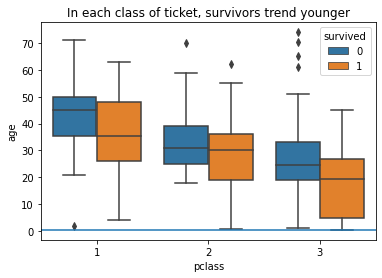

In [41]:
# At each class ticket, women have better survival rates
plt.title("In each class of ticket, survivors trend younger")
sns.boxplot(x="pclass", y="age", data=train, hue="survived")
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate)
plt.show()


Note A scatterplot of 2 numeric columns by one or two categorical columns might be very useful for numeric targets on your y axis

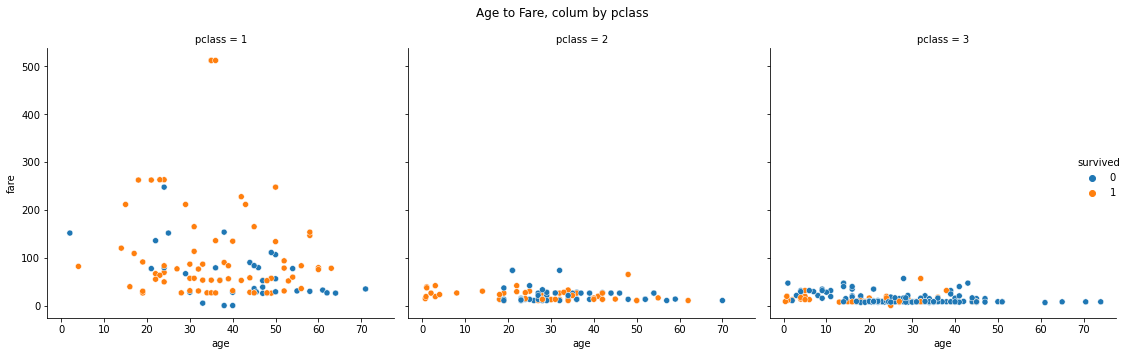

In [42]:
# No discernable relationship between age and fare, but the pclass relates to survival
rel = sns.relplot(x='age', y='fare', data=train, col="pclass", hue="survived")
rel.fig.suptitle('Age to Fare, colum by pclass') # One way to title a relplot
plt.tight_layout()


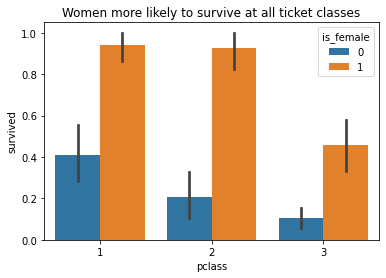

In [43]:
plt.title("Women more likely to survive at all ticket classes")
sns.barplot(x="pclass", y="survived", hue="is_female", data=train)
population_survival_rate = train.survived.mean()
plt.show()


In [44]:
women_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 1)]
men_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 0)]

print(f"Overall survival rate:", round(train.survived.mean(), 2))
print(f"Overall female survival rate", round(train[train.is_female == 1].survived.mean(), 2))
print(f"Overall male survival rate", round(train[train.is_female == 0].survived.mean(), 2))
print(f"3rd class ticket survival rate", round(train[train.pclass == 3].survived.mean(), 2))
print(f"Survival rate for women in 3rd class:", round(women_in_3rd_class.survived.mean(), 2))
print(f"Survival rate for men in 3rd class:", round(men_in_3rd_class.survived.mean(), 2))


Overall survival rate: 0.4
Overall female survival rate 0.75
Overall male survival rate 0.2
3rd class ticket survival rate 0.21
Survival rate for women in 3rd class: 0.46
Survival rate for men in 3rd class: 0.1


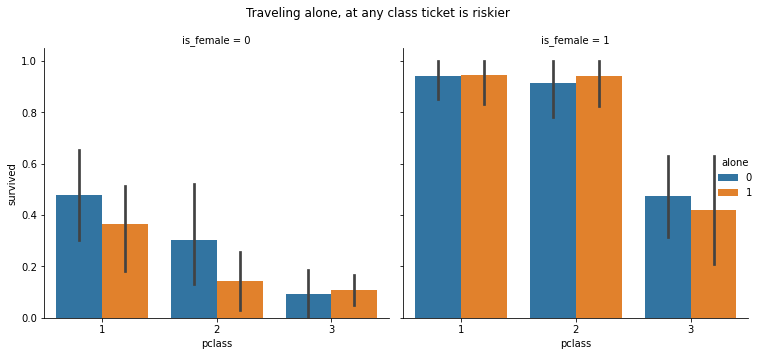

In [48]:
cat = sns.catplot(data=train, x="pclass", y="survived", hue="alone", col="is_female", kind="bar")
cat.fig.suptitle("Traveling alone, at any class ticket is riskier for men")
plt.tight_layout()


# Takeaways 
1. Women more likely to survive at all ticket classes 
2. In each class of ticket, survivors trend younger 
3. First class alone has better survival than 3rd class traveling with family 
4. Fare and age don't seem to correlate, but fare and class of ticket appear related. 
5. For both men and women passengers, survival and pclass are dependent

- What do you learn from these? What are some actions you wish to take?



In [49]:
# Gender subset setup
male_subset = train[train.is_female == 0]
female_subset = train[train.is_female == 1]


In [50]:
null_hypothesis = "survival and pclass are independent for female passengers"
alternative_hypothesis = "survival and pclass are dependent for female passengers"

alpha = 0.05
observed = pd.crosstab(female_subset.survived, female_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)


We reject the null hypothesis that survival and pclass are independent for female passengers
Evidence suggests that survival and pclass are dependent for female passengers


In [51]:
null_hypothesis = "survival and pclass are independent for male passengers"
alternative_hypothesis = "survival and pclass are dependent for male passengers"

alpha = 0.05
observed = pd.crosstab(male_subset.survived, male_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)


We reject the null hypothesis that survival and pclass are independent for male passengers
Evidence suggests that survival and pclass are dependent for male passengers


# Get Creative

Ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population. We then answer these questions using visualizations and/or hypothesis testing.

-Is there a relationship between survival and parch for women travelers?

-Is there a relationship between survival and parch for male travelers?

-Is there a relationship between survival and sibsp for women travelers?

-Is there a relationship between survival and sibsp for male travelers?

What other subgroups can you create and visualize?

What variables have you not worked with yet?

What other subgroups can you create and test?

## Conclusion

Here we pull all of our takeaways and actions together into one place we can reference as we move forward. - Overall, 60% did NOT survive. This will be my baseline prediction to test the usefulness of features on later when we get to modeling. - Younger people appear more likely to survive. A new feature of is_child might be helpful, or maybe binning age into 3 groups of "young", "middle", and "older" would be more helpful than age as a numeric column, alone. - Take all of your takeaways and document them in one place. - If we have time, maybe on a second draft, we can dive deep into more variable pairings.

# Work fast to an MVP understanding of your data

-Focus on features that give you the biggest bang for your buck.

-If there's 30% of a population that's responsible for 99% of the sales, starting with breaking down that 30% population into different groups

# When you have time for a second draft

-Revisit some of the things you may have skipped earlier in order to get to an MVP.

-For example, there were ~20% of rows with missing age. If you have time, check these out. Is there a set of the population that is similar such that we can impute an expected age value?

# Explore creating your own features

-Turning numeric columns like age into a category with is_child, for example with a boolean.

-Where does it make logical sense to combine columns

In [6]:
missing_age = df[df.age.isna()]
missing_age.head().T

,5,17,19,26,28
passenger_id,5,17,19,26,28
survived,0,1,1,0,1
pclass,3,2,3,3,3
sex,male,male,female,male,female
age,NaN,NaN,NaN,NaN,NaN
sibsp,0,0,0,0,0
parch,0,0,0,0,0
fare,8.4583,13.0,7.225,7.225,7.8792
embarked,Q,S,C,C,Q
class,Third,Second,Third,Third,Third
